In this python notebook, I am trying to implement this paper:

Using shallow neural networks with functional connectivity from EEG signals for early diagnosis of Alzheimer’s and frontotemporal dementia


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()


'/content'

In [4]:
!gdown https://drive.google.com/uc?id=1F8_EwdiUqCJ0ekXD1KQiOeHCJdk9dU2m


Downloading...
From (original): https://drive.google.com/uc?id=1F8_EwdiUqCJ0ekXD1KQiOeHCJdk9dU2m
From (redirected): https://drive.google.com/uc?id=1F8_EwdiUqCJ0ekXD1KQiOeHCJdk9dU2m&confirm=t&uuid=394022b1-f21d-414c-a945-2e29d97450c4
To: /content/Epoched_EEGdata_Preprocessed_Manually.mat
100% 727M/727M [00:11<00:00, 61.7MB/s]


In [4]:
!ls

drive  Epoched_EEGdata_Preprocessed_Manually.mat  sample_data


## Read data in .mat format

In [31]:
from scipy.io import loadmat
data = loadmat('/content/Epoched_EEGdata_Preprocessed_Manually.mat')


In [32]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'EEG_Class', 'epoch_num'])

## plot data to get an intuition

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Inspect the EEG_Class structure
EEG_data = data['EEG_Class']




In [8]:
EEG_data.shape

(1, 88)

In [9]:
type(EEG_data)

numpy.ndarray

In [34]:
# trimming
eeg_data_trimmed = EEG_data[:, :65]
eeg_data_trimmed.shape

(1, 65)

In [35]:
import random
import numpy as np

np.random.seed(9)
subjects = random.choice(range(len(EEG_data[0])))

print("Number of Channels for this Subject is: ", EEG_data[0][8].shape[1])
print("Number of Epoches for this Subject is: ", EEG_data[0][8].shape[2])
print("And in each Epoch we have: ", EEG_data[0][17].shape[0])
subjects

Number of Channels for this Subject is:  19
Number of Epoches for this Subject is:  41
And in each Epoch we have:  2500


57

# Creating labels

In [12]:
eeg_data_trimmed[0].shape

(65,)

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [9]:
import numpy as np
#import ipdb

_ , index = eeg_data_trimmed.shape


labels= []
for i in range(index):
  _ , num_of_channels, num_of_epochs = eeg_data_trimmed[0][i].shape
  if i < 37:
    labels.append(np.ones((num_of_channels, num_of_epochs), dtype=int))
  else:
    #set_trace()
    labels.append(np.zeros((num_of_channels, num_of_epochs), dtype=int))


In [10]:
counter = [eeg_data_trimmed[0][i].shape[2] for i in range(65)]
min(counter)


13

## Extract Temporal Channels

In [23]:
initial_data = eeg_data_trimmed[0]
reshaped_data = np.expand_dims(eeg_data_trimmed[0][0], axis=0)
final_data = np.repeat(reshaped_data, initial_data.shape[0], axis=0)
final_data= final_data[:,:,13:17,:]
X = final_data


# search : cut or zero padding

In [24]:
X.shape

(65, 2500, 4, 46)

In [15]:
X = X.reshape(65, 2500*4, 13)
X.shape

(65, 10000, 13)

In [16]:
y = np.array([1]*36 + [0]*29)

IndexError: index 4 is out of bounds for axis 1 with size 4

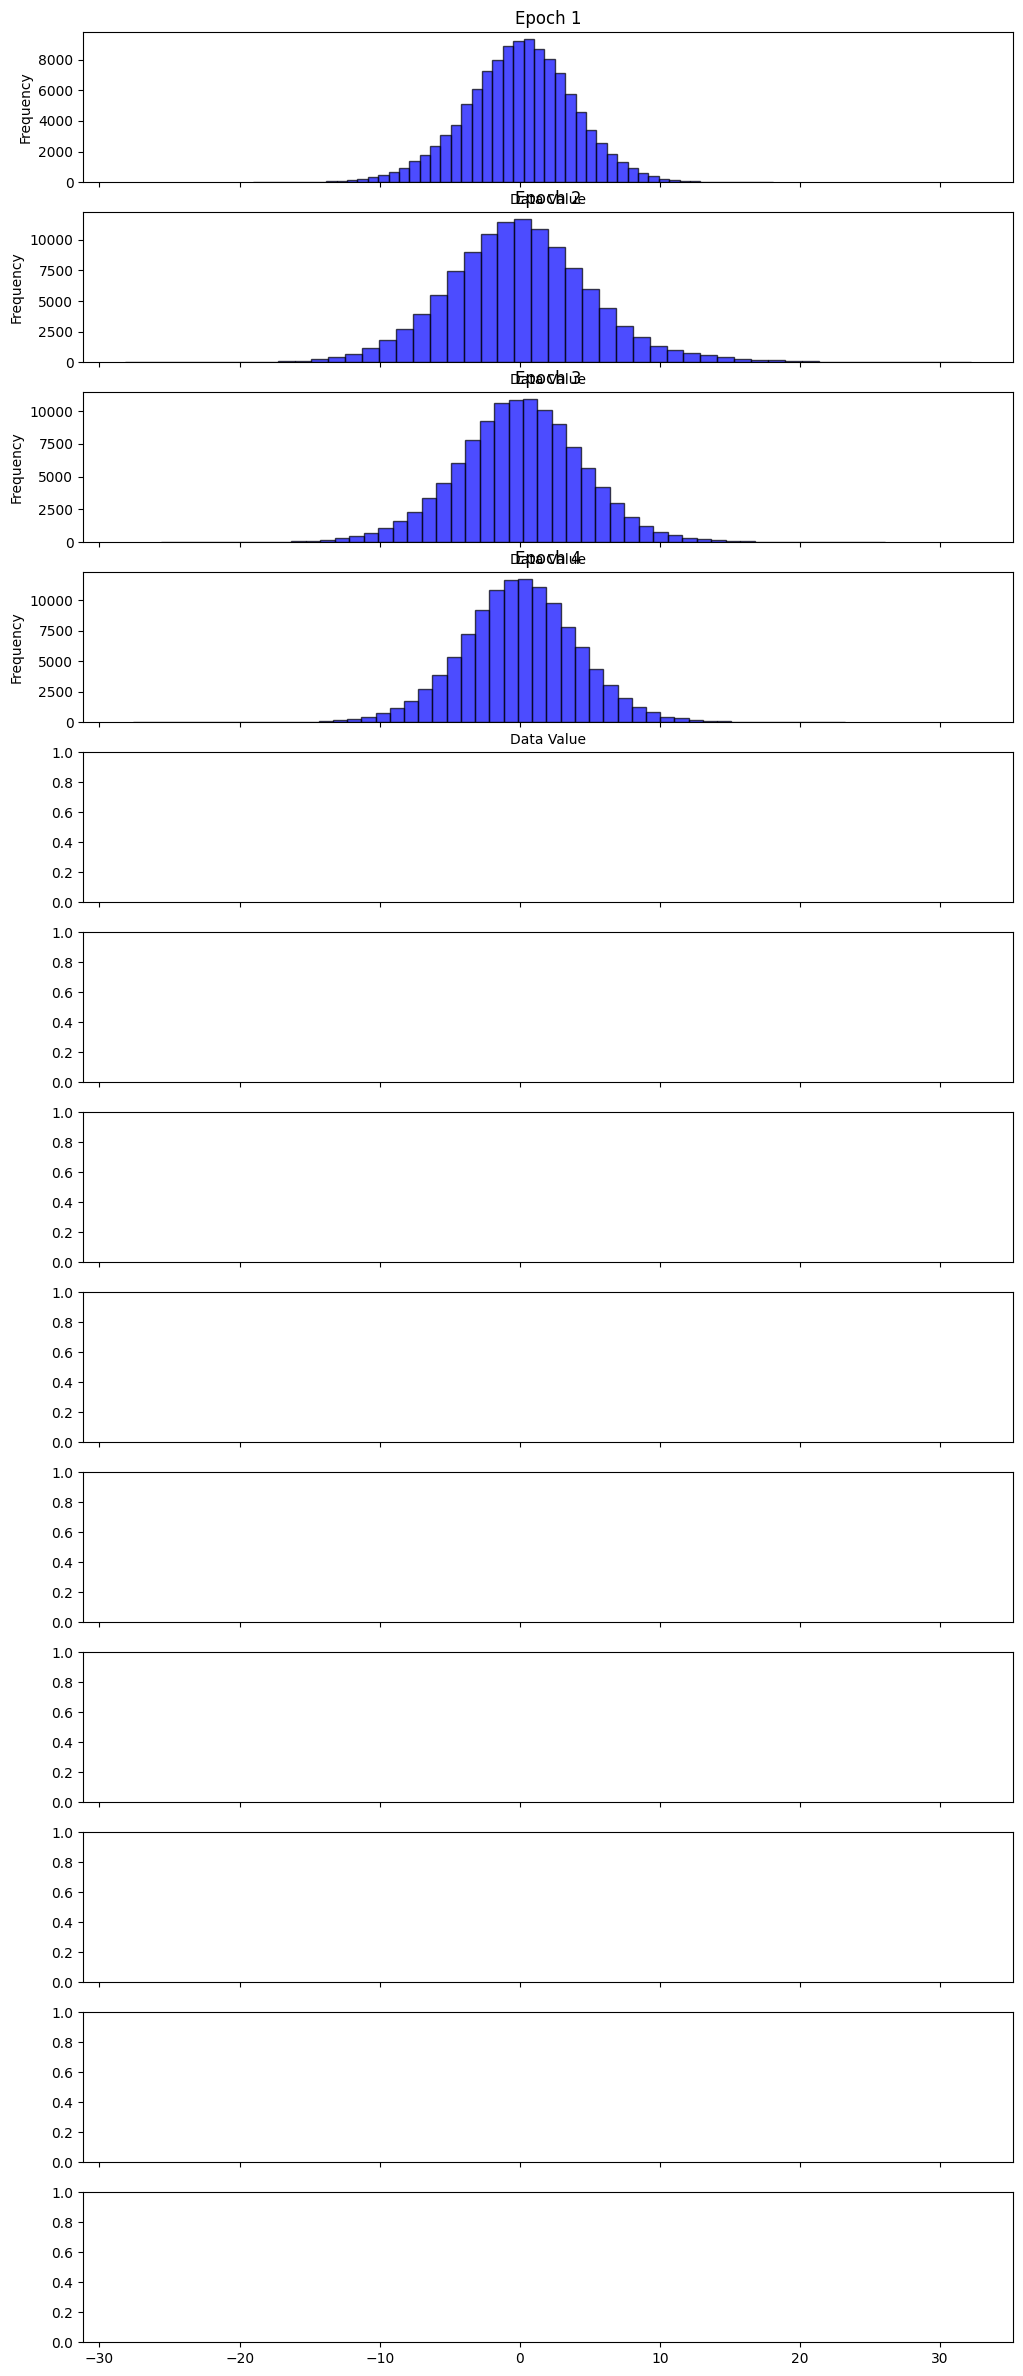

In [45]:
random_index = np.random.choice(X.shape[0])
random_subject_data = X[random_index]

# Step 3: Create subplots
fig, axes = plt.subplots(13, 1, figsize=(12, 30), sharex=True)

# Step 4: Plot each epoch's distribution
for epoch in range(13):
    epoch_data = random_subject_data[:, epoch].flatten()  # Extract and flatten data for the current epoch
    axes[epoch].hist(epoch_data, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[epoch].set_title(f'Epoch {epoch + 1}')
    axes[epoch].set_xlabel('Data Value')
    axes[epoch].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Optional: Print selected subject index
print(f'Randomly selected subject index: {random_index}')

# Train/ Test Split

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split


# Normalize data
# X_normalized = X / np.max(X, axis=2, keepdims=True)
# should I normalize?


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  shuffle = False)


# Model based on the paper

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, learning_rate):
    model = Sequential([
        # First block of conv, batch norm, and max pooling

        Conv1D(50, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Second block of conv, batch norm, and max pooling
        Conv1D(50, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),


        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.1),  # Add dropout for regularization
        Dense(1, activation='sigmoid')
    ])

    return model

#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

model = create_cnn_model((10000,13), 0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 9996, 50)          3300      
                                                                 
 batch_normalization_2 (Bat  (None, 9996, 50)          200       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4998, 50)          0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 4994, 50)          12550     
                                                                 
 batch_normalization_3 (Bat  (None, 4994, 50)          200       
 chNormalization)                                                
                                                      

In [21]:
hist = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
2/2 [==============================] - 5s 2s/step - loss: 0.6797 - accuracy: 0.6923
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 0.6795 - accuracy: 0.6923
Epoch 3/50
2/2 [==============================] - 5s 2s/step - loss: 0.6791 - accuracy: 0.6923
Epoch 4/50
1/2 [==============>...............] - ETA: 2s - loss: 0.6769 - accuracy: 0.7188

KeyboardInterrupt: 

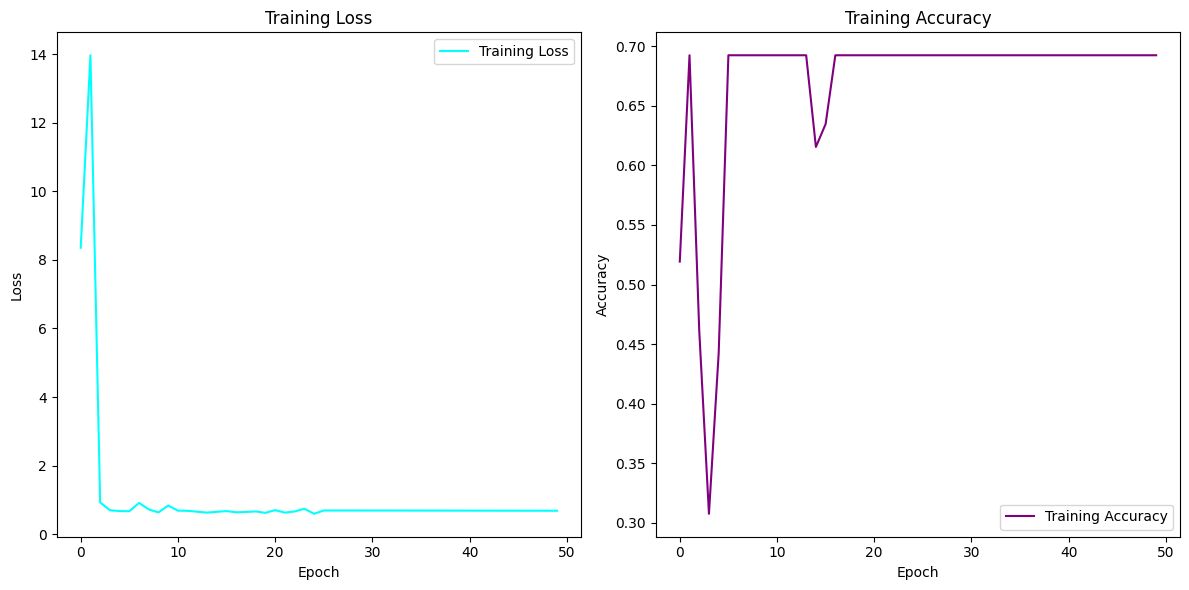

In [86]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
 training_accuracy = hist.history['accuracy']
 training_accuracy

[0.5020437836647034,
 0.6467854976654053,
 0.6890560984611511,
 0.6913789510726929,
 0.6923074126243591,
 0.692307710647583,
 0.6923075318336487,
 0.6923075318336487,
 0.692307710647583,
 0.6923075914382935,
 0.6923074126243591,
 0.6923075318336487,
 0.6923079490661621,
 0.692307710647583,
 0.6923080086708069,
 0.6923075318336487,
 0.692307710647583,
 0.6923080682754517,
 0.6923080086708069,
 0.6923075914382935,
 0.692307710647583,
 0.6923080086708069,
 0.6923075318336487,
 0.6923080086708069,
 0.6923073530197144,
 0.6923075318336487,
 0.6923075318336487,
 0.6923080086708069,
 0.6923075318336487,
 0.6923075914382935,
 0.692307710647583,
 0.6923075318336487,
 0.692307710647583,
 0.692307710647583,
 0.6923079490661621,
 0.6923075318336487,
 0.6923075318336487,
 0.6923075318336487,
 0.6923079490661621,
 0.692307710647583,
 0.6923075318336487,
 0.692307710647583,
 0.6923080086708069,
 0.6923075318336487,
 0.6923073530197144,
 0.6923074126243591,
 0.6923079490661621,
 0.6923074126243591,
 0

In [ ]:
y_train

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0])